# Project 01: one protein against many ligands 

## Generating a Shared Interaction Profile for Mpro Structures

The purpose is to find interaction hotspots in a single target through the analysis of interactions found in a dataset of diverse small compounds.

This pipeline was used to elucidate hotspots in the sars-cov-19 protease (**Mpro**), using the structures available from [Fragalysis](https://fragalysis.diamond.ac.uk/).

The workflow itself consists of three steps:

1. Obtaining and sanitizing the data
2. Ingesting it in `plipify`
3. Generating publication-worthy figures

In [1]:
from pathlib import Path
from io import BytesIO
from zipfile import ZipFile
from subprocess import call, STDOUT

import requests
from tqdm.auto import tqdm
from matplotlib import cm, colors
from IPython.display import Image
import pandas as pd
from rdkit.Chem.PandasTools import AddMoleculeColumnToFrame
from Bio.PDB import PDBParser, PDBIO
import nglview as nv

from plipify.fingerprints import InteractionFingerprint
from plipify.visualization import (
    fingerprint_barplot, fingerprint_heatmap, fingerprint_table, 
    fingerprint_nglview, PymolVisualizer, nglview_color_side_chains_by_frequency,
    fingerprint_writepdb
)
from plipify.core import Structure

## Obtaining and sanitizing the data

### Select target of interest
Query Fragalysis for all downloadable targets.

In [2]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json")
r.raise_for_status()
targets = [t["title"] for t in r.json()["results"] if t["zip_archive"]]
print("Downloadable targets:", *targets)

Downloadable targets: NUDT7A ATAD BRD1A DCP2B FAM83BA MURD NUDT4A OXA10OTA PARP14A PHIPA PTP1B SMTGR ACVR1A ATAD2A CAMK1DA DCLRE1AA FALZA HAO1A MUREECA NUDT21A NUDT4 NUDT5A NUDT7A_CRUDE smTGRNEW STAG1A TBXTA VIM2 XX02KALRNA TNCA ALAS2A EPB41L3A mArh INPP5DA nsp13 Mac1 Mpro NSP15_B MUREECOLI PGN_RS02895PGA CD44MMA


In [3]:
TARGET = "Mpro"  # other options, see above

HERE = Path(_dh[-1])
DATA = HERE / "data" / TARGET
OUT = HERE / "output" / TARGET
DATA.mkdir(exist_ok=True, parents=True)
OUT.mkdir(exist_ok=True, parents=True)

### Get data from fragalysis

We will be using data from [_Fragalysis_](https://fragalysis.diamond.ac.uk/), a XRC platform that generates structures for ligand collections against a given target. API endpoint is described [here](https://fragalysis.diamond.ac.uk/api/?format=api), but in short, it seems that you can download a full featured zip file using this URL: `https://fragalysis.diamond.ac.uk/media/targets/$TARGETNAME.zip`.

In [4]:
r = requests.get(f"https://fragalysis.diamond.ac.uk/api/targets/?format=json&title={TARGET}")
r.raise_for_status()
target = r.json()["results"][0]

if target["zip_archive"] is None:
    raise ValueError(f"Target {TARGET} is not downloadable")

crystal_name RealCrystalName  \
1     Mpro-x11271_0A     Mpro-x11271   
2     Mpro-x11041_0A     Mpro-x11041   
3      Mpro-x1002_0A      Mpro-x1002   
4     Mpro-x10155_0A     Mpro-x10155   
6      Mpro-x1101_1A      Mpro-x1101   
...              ...             ...   
1270   Mpro-P2010_0A      Mpro-P2010   
1271   Mpro-P2011_0A      Mpro-P2011   
1272   Mpro-P0154_0A      Mpro-P0154   
1273   Mpro-P1062_0B      Mpro-P1062   
1274   Mpro-P1062_0A      Mpro-P1062   

                                                 smiles  \
1                COC=1C=C(Cl)C=C(CC(=O)NC=2C=NC=CC2C)C1   
2                 CN(C(=O)CC=1C=CC=C(Cl)C1)C=2C=NC=CC2C   
3                                          OC=1C=CC=CN1   
4                   CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O   
6                         CC(C)N(C)C=1N=CN=C2N(C)N=CC12   
...                                                 ...   
1270          ClC=1C=CC=C(CC(=O)NC=2C=NC=C3N=CC=CC23)C1   
1271            ClC=1C=CC=C(CC(=O)NN2N=NC=3C=CC=CC23)C1   
1272  ClC=1C=CC=2OCCC(CNC(=O)CN3C=CN=C3)(C(=O)NC=4C=...   
1273  CC1CCN(C1)S(=O)(=O)N2CC(C(=O)NC=3C=NC=C4C=CC=C...   
1274  CC1CCN(C1)S(=O)(=O)N2CC(C(=O)NC=3C=NC=C4C=CC=C...   

                               new_smiles       alternate_name  \
1                                     NaN   MAT-POS-c9973a83-1   
2                                     NaN  JAN-GHE-83b26c96-15   
3                                     NaN  AAR-POS-0daf6b7e-37   
4     CC(N1CCN(Cc2cnc(Cc3ccccc3)s2)CC1)=O  MED-COV-4280ac29-25   
6                                     NaN  AAR-POS-0daf6b7e-40   
...                                   ...                  ...   
1270                                  NaN   MIC-UNK-08cd9c58-1   
1271                                  NaN   MAT-POS-bfb445d4-2   
1272                                  NaN   EDG-MED-70ae9412-1   
1273                                  NaN  MAT-POS-4223bc15-11   
1274                                  NaN  MAT-POS-4223bc15-11   

                        site_name pdb_entry  \
1              Aminopyridine-like       NaN   
2              Aminopyridine-like       NaN   
3     XChem Screen - xtal contact      5RF4   
4                 Chloroacetamide       NaN   
6     XChem Screen - xtal contact      5RGR   
...                           ...       ...   
1270                 Isoquinoline       NaN   
1271                Benzotriazole       NaN   
1272                 Isoquinoline       NaN   
1273                 Isoquinoline       NaN   
1274                 Isoquinoline       NaN   

                                                  ROMol  
1     <img data-content="rdkit/molecule" src="data:i...  
2     <img data-content="rdkit/molecule" src="data:i...  
3     <img data-content="rdkit/molecule" src="data:i...  
4     <img data-content="rdkit/molecule" src="data:i...  
6     <img data-content="rdkit/molecule" src="data:i...  
...                                                 ...  
1270  <img data-content="rdkit/molecule" src="data:i...  
1271  <img data-content="rdkit/molecule" src="data:i...  
1272  <img data-content="rdkit/molecule" src="data:i...  
1273  <img data-content="rdkit/molecule" src="data:i...  
1274  <img data-content="rdkit/molecule" src="data:i...  

[587 rows x 8 columns]
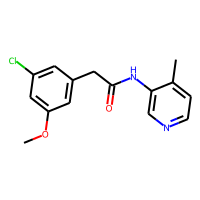
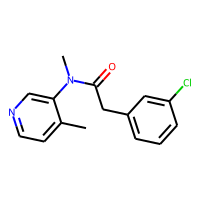
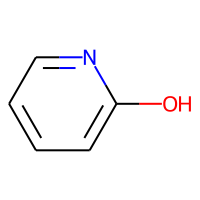
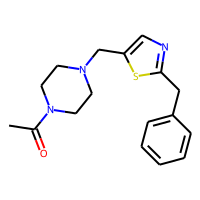
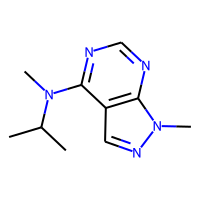
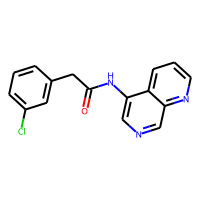
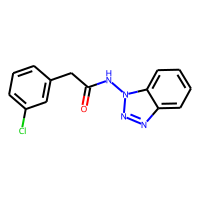
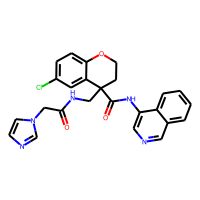
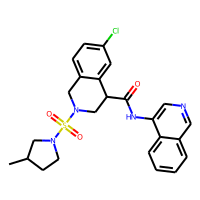
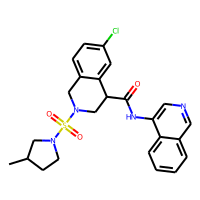

In [5]:
metadata = requests.get(target["metadata"], stream=True)
metadata = pd.read_csv(metadata.raw, index_col=0)
AddMoleculeColumnToFrame(metadata, smilesCol="smiles")
metadata

Prealigned PDBs for each row can be found in `data/{target}/aligned/{crystal_name}/{crystal_name}_bound.pdb`:

In [6]:
# If already downloaded, they should be here:
pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))

if not pdbs:
    download_url = target["zip_archive"]
    
    # NOTE: As of 2021.10.13, MPro dataset URL gives a 502 gateway error
    # The webapp uses https://zenodo.org/record/5226381 instead for MPro
    # We will use this one for now if that's the case
    if target["title"] == "Mpro":
        download_url = "https://zenodo.org/record/5226381/files/Mpro.zip?download=1"
        
    response = requests.get(download_url, stream=True)
    response.raise_for_status()
    with BytesIO(response.raw.data) as b, ZipFile(b) as z:
        z.extractall(DATA)
    # Reassign now
    pdbs = list((DATA / "aligned").glob("**/*_bound.pdb"))
    assert pdbs, "Couldn't find downloaded PDB structures!"
    
print(f"# structures: {len(pdbs)}")

# structures: 493


The archive for MPro keeps changing contents (more structures being added), so we will filter the structures with the contents retrieved on 2021.07.07 for the sake of reproducibility.

In [7]:
if TARGET == "Mpro":
    all_pdbs = pdbs.copy()
    with open(HERE / "20210707_Mprodata.txt") as f:
        contents = set()
        for line in f:
            line = line.strip()
            if line.endswith(".pdb"):
                contents.add(line)
    pdbs = [pdb for pdb in all_pdbs 
            if str(Path(pdb).relative_to(HERE)) in contents]
    print("Filtered structures down to", len(pdbs), "files")

Filtered structures down to 493 files


As the directory name suggests, these are prealigned:contents

In [8]:
view = nv.NGLWidget()
for pdb in pdbs[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

In [9]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

In [10]:
view._display_image()

Notice how binding sites are not always the same.

### Prepare data

#### Split files by chain
To get one binding site per protein only

In [11]:
# If already split, they should be here:
pdbs_by_chain = list((DATA / "aligned").glob("**/*_bound_chain*[!wH].pdb"))
not_processed = []
    
if not pdbs_by_chain:
    for path in tqdm(pdbs):
        chain_id = path.stem.split('_')[1][-1]
        new_filename = path.parent / f"{path.stem}_chain{chain_id}{path.suffix}"

        ## Read the PDB file and extract the chain from structure[0]
        model = PDBParser(PERMISSIVE=1,QUIET=1).get_structure(pdb_id, filepath)[0]
        ### Save new file
        if chain_id in model:
            io = PDBIO()
            io.set_structure(model[chain_id])
            io.save(str(new_filename))
        else:
            not_processed.append(path)
    
    # Reassign now
    pdbs_by_chain = list((DATA / "aligned").glob("**/*_bound_chain*[!wH].pdb"))

print(f"# structures: {len(pdbs_by_chain)}")
if(len(not_processed)>0):
    print(f"Could not process {len(not_processed)} structures:")
    print(" -", "\n - ".join(map(str, not_processed)))

# structures: 493


#### Protonate
Some ligands/residues are potentially incorrectly protonated with PLIP builtin fixers (OpenBabel). In this example, we take care of that using Amber's `reduce`.

In [12]:
def reduce(path):
    path = Path(path)
    output = path.parent / f"{path.stem}_wH{path.suffix}"
    with open(output, "wb") as f:
        call(["reduce", path], stdout=f, stderr=STDOUT)
    return output

In [13]:
# If already Hs added, they should be here:
pdbs_by_chain_wH = list((DATA / "aligned").glob("**/*_bound_chain*_wH.pdb"))

if not pdbs_by_chain_wH:
    pdbs_by_chain_wH = [reduce(pdb) for pdb in tqdm(pdbs_by_chain)]

print(f"# structures: {len(pdbs_by_chain_wH)}")
print(" -", "\n - ".join(map(str, pdbs_by_chain_wH[0:3])))

# structures: 493
 - /home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0A/Mpro-P0008_0A_bound_chainA_wH.pdb
 - /home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0008_0B/Mpro-P0008_0B_bound_chainB_wH.pdb
 - /home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0009_0A/Mpro-P0009_0A_bound_chainA_wH.pdb


Check structures

In [14]:
import nglview as nv

view = nv.NGLWidget()
for pdb in pdbs_by_chain_wH[:10]:
    structure = nv.adaptor.FileStructure(str(pdb))
    comp = view.add_component(structure, default_representation=False)
    comp.add_cartoon()
    comp.add_ball_and_stick("LIG")
view.center("LIG")
view

NGLWidget()

## Ingesting it in `plipify` 

* `plipify` will be used for interaction hotspot analysis across a set of ligands co-crystalliezed to the same protein.
* It is built on top of Protein–Ligand Interaction Profiler, or [PLIP](https://plip-tool.biotec.tu-dresden.de/plip-web/plip/index), used to get insight into protein-ligand interactions. 

### Build structure and binding site from pdb
For this exercise, we will only keep structures that contain exactly one binding site.

In [15]:
structures = []
for path in tqdm(pdbs_by_chain_wH):
    structure = Structure.from_pdbfile(str(path), ligand_name="LIG")
    if len(structure.binding_sites) != 1:
        print(f"{path.relative_to(HERE)} contains {len(structure.binding_sites)} binding sites and we want exactly one.")
        continue
    structures.append(structure)

  0%|          | 0/493 [00:00<?, ?it/s]

data/Mpro/aligned/Mpro-x1101_0A/Mpro-x1101_0A_bound_chainA_wH.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x1101_1A/Mpro-x1101_1A_bound_chainA_wH.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_0A/Mpro-x12025_0A_bound_chainA_wH.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-x12025_1A/Mpro-x12025_1A_bound_chainA_wH.pdb contains 2 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0A/Mpro-z2zu2_0A_bound_chainA_wH.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_0B/Mpro-z2zu2_0B_bound_chainB_wH.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z2zu2_1A/Mpro-z2zu2_1A_bound_chainA_wH.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0A/Mpro-z4ylu_0A_bound_chainA_wH.pdb contains 0 binding sites and we want exactly one.
data/Mpro/aligned/Mpro-z4ylu_0B/Mpro-z4ylu_0B_bound_chainB_wH.pdb co

### Rudimentary filter to exclude artifacts

Since the structures can have slight differences, we exclude some of them a priori, because they will cause problems in the current `plipify version.

Exclude structures
* by sequence length deviation
* and those containing gaps
* **tmp fix**: Needed to revert the structure list, otherwise the different sequence sizes (304 and 305) caused an error, and excluded one structure at the end for same reason (#TODO)

Note: The gap filter was neede to avoid error when generating interatcion fingerprints `ValueError: Length mismatch: Expected axis has 296 elements, new values have 305 element`

In [16]:
# keep a copy around for testing only
_structures = structures.copy()

In [17]:
structures.reverse()
# TODO check why it does not work with the below sorted version
# when building the fingerprints below
# structures.sort(key=lambda s: len(s.sequence()), reverse=True)

Collect data to remove entries 
* where the difference sequence length - median sequence length is greater than one standard deviation
* that contian gaps

In [18]:
lengths = pd.DataFrame([((s.identifier), len(s.sequence()), s.sequence()) for s in structures], columns=["identifier", "length", "sequence"])
print('Sequence length median and std:', lengths.length.median(), lengths.length.std())

Sequence length median and std: 304.0 1.3704707370361833


In [19]:
lengths["gapcount"] = lengths.sequence.str.count('-')
lengths[lengths.gapcount>0]

identifier  length  \
5    Mpro-z5gwy_0A_bound_chainA_wH     300   
7    Mpro-z3d23_0C_bound_chainC_wH     299   
9    Mpro-z3d23_0A_bound_chainA_wH     300   
377  Mpro-P0661_0B_bound_chainB_wH     305   
382  Mpro-P0602_0B_bound_chainB_wH     305   
393  Mpro-P0208_0B_bound_chainB_wH     305   

                                              sequence  gapcount  
5    --LKKMAQPSGCVERCVVRVCYGSTVLNGVWLGDTVTCPRHVIAPS...         2  
7    -GIVKMVSPTSKIEPCIVSVTYGSMTLNGLWLDDKVYCPRHVICSS...         1  
9    SGIVKMVSPTSKIEPCIVSVTYGSMTLNGLWLDDKVYCPRHVICS-...         3  
377  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVI---...         9  
382  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         7  
393  SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVIC--...         6

Exclude entries with varying sequence length

In [20]:
lengths = lengths[(lengths.length - lengths.length.median()).abs() < lengths.length.std()]

Exclude entries with gaps

In [21]:
lengths = lengths[lengths.gapcount==0]

Collect the filtered structures accordingly

In [22]:
filtered_structures = [s for s in structures if s.identifier in set(lengths.identifier.tolist())]

print('Starting with: pdbs', len(pdbs_by_chain_wH), "-> structures", len(structures), "-> final", len(filtered_structures))
print(f'Note: {len(pdbs_by_chain_wH) - len(filtered_structures)} structures filtered out.')

structures = filtered_structures

Starting with: pdbs 493 -> structures 466 -> final 392
Note: 101 structures filtered out.


Count type of structures

In [23]:
n_structures_by_type = {'Mpro-P': 0, 'Mpro-x': 0, 'Mpro-z': 0, 'other': 0}
for s in structures:
    name_code = s.identifier[0:6]
    if name_code in n_structures_by_type:
        n_structures_by_type[name_code] += 1
    else:
        n_structures_by_type['other'] += 1
print(n_structures_by_type)

{'Mpro-P': 32, 'Mpro-x': 359, 'Mpro-z': 1, 'other': 0}


### Generate interaction fingerprint

In [24]:
# Review
fp = InteractionFingerprint().calculate_fingerprint(
        structures[1:], # see comment above excluded Mpro-z structure
        labeled=True, 
        as_dataframe=True, 
        remove_non_interacting_residues=True,
        remove_empty_interaction_types=True,
        ensure_same_sequence=False
    )

if not fp.values.shape[0]:
    raise ValueError("Fingerprint is empty!")

Show interaction overview table

In [25]:
fp.style.background_gradient(axis=None, cmap="YlGnBu")

This fingerprint is too sparse, let's try to focus on the hotspots only (arbitrarily defined now as "residue with more than 5 total interactions, regardless the type")

In [26]:
fp_focused = fp[fp.sum(axis=1) > 5]

In [27]:
fp_focused.style.background_gradient(axis=None, cmap="YlGnBu")

## Analyse and visualize the results

* First, we will look at the different representations for the interation hot spots.
* Then, we will visualize the interactions in 3D
    * nglview
    * pymol

### Interaction visualizations: Barplot, heatmap and table

`plipify` provides several views for the aggregated interaction fingerprints.

#### Barplot

In [28]:
fingerprint_barplot(fp_focused)

#### Heatmap

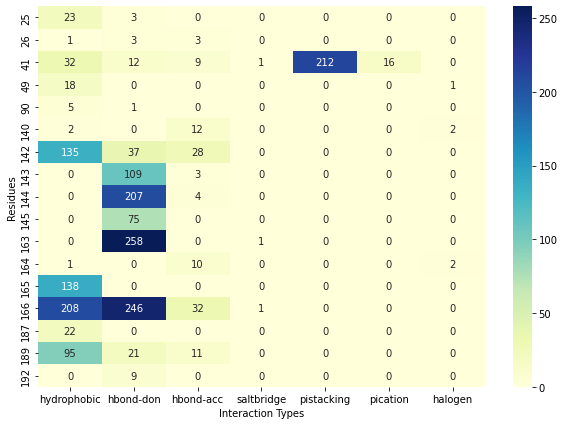

In [29]:
fingerprint_heatmap(fp_focused, cmap="YlGnBu");

#### Table

In [30]:
fingerprint_table(fingerprint_df=fp_focused, structure=structures[0])

HTML(value='\n    <style>\n    \n\n    table.plipify-legend {\n        text-align: center;\n        color: #ff…

### 3D Visualization

#### Pick a structure for drawing purposes
* We pick the lead compound methoxy for visualization purposes
* Contained in the structure **Mpro-P0157_0B**

In [31]:
structures[0].identifier

'Mpro-z2q6g_0A_bound_chainA_wH'

In [32]:
selected_name = "Mpro-P0157_0B"  
selected_structure = next(s for s in structures if selected_name in s.identifier)
selected_pdb = next(p for p in pdbs_by_chain_wH if selected_name in str(p))

#### Visualizations using nglview

Color side chains by frequency of interactions they contribute to.

In [33]:
view = nglview_color_side_chains_by_frequency(fp_focused, selected_pdb)
view.center("LIG")
view

NGLWidget()

Show specific interactions for a protein-ligand complex.

In [34]:
view = fingerprint_nglview(fp_focused, selected_structure)
view.center("LIG")
view

NGLWidget()

In [35]:
view.render_image(factor=1, trim=True, transparent=True, antialias=True);

In [36]:
view._display_image()

Show information generated by PLIP for a specific complex.

In [37]:
selected_structure.to_dataframes();

### LIG:B:501

#### Hydrophobic

RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
0   165     MET        B       501         LIG            B  3.72   
0   166     GLU        B       501         LIG            B  3.89   

  LIGCARBONIDX PROTCARBONIDX                    LIGCOO  \
0         4682          2522  (-21.709, 2.983, 30.571)   
0         4700          2539   (-17.143, 6.22, 25.503)   

                    PROTCOO  
0  (-18.331, 1.657, 31.378)  
0  (-15.339, 5.818, 28.925)

#### Hbond-Don

RESNR RESTYPE RESCHAIN RESNR_LIG RESTYPE_LIG RESCHAIN_LIG SIDECHAIN  \
0   166     GLU        B       501         LIG            B     False   
0   144     SER        B       501         LIG            B      True   
0   163     HIS        B       501         LIG            B      True   

  DIST_H-A DIST_D-A DON_ANGLE PROTISDON DONORIDX DONORTYPE ACCEPTORIDX  \
0     2.07     2.89    158.13      True     2537       Nam        4678   
0     3.63     3.86    100.12      True     2223        O3        4702   
0     1.74     2.68    159.18      True     2494       Nar        4702   

  ACCEPTORTYPE                    LIGCOO                   PROTCOO  
0           O2  (-19.338, 4.837, 29.465)  (-16.623, 3.958, 29.928)  
0          Nar  (-16.928, 3.849, 25.934)   (-16.516, 2.518, 22.33)  
0          Nar  (-16.928, 3.849, 25.934)  (-15.838, 1.406, 26.154)

#### Generating publication-worthy figures

We provide here a semi-automated pipeline, to generate high-resolution figures of the interaction frequencies mapped on the protein structure, using pymol.

Below is an example of 
1) Creating PDB files for each interaction type found by `InteractionFingerprint().calculate_fingerprint()` (Frequencies are stored in the b-factor columns). 
2) Producing images of these using the PyMol API.

Note: The current hard-coded view is based on the aligned MPro structures.

In [38]:
selected_pdb

PosixPath('/home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0157_0B/Mpro-P0157_0B_bound_chainB_wH.pdb')

In [39]:
# Using the methoxy ligand as an example
print(f' Selected structure: {selected_pdb}')
methoxy = Structure.from_pdbfile(path=str(selected_pdb))

 Selected structure: /home/andrea/devel/py/plipify/projects/01/data/Mpro/aligned/Mpro-P0157_0B/Mpro-P0157_0B_bound_chainB_wH.pdb


Write interaction hotspots to a PDB file

* Create individual PDB files based on the interaction type.
* This will produce PDB files with bfactor values per residue representing the number of ligand interactions at that particular site. 

We also set the `summed` flag to `True` to add up all interactions and generate a PDB file containing all interaction types summed together.

In [40]:
pdb_interactions = fingerprint_writepdb(fingerprint_df=fp, structure=methoxy, output_path=OUT, ligand=True, summed=True, verbose=False)

/home/andrea/.local/miniconda/envs/plipify/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:747: UserWarning:

Unit cell dimensions not found. CRYST1 record set to unitary values.



One structure object per interaction type is created, as well as one for the summed interactions over all types.

In [41]:
pdb_interactions['hydrophobic']

<Structure with 305 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/home/andrea/devel/py/plipify/projects/01/output/Mpro/interaction_pdbs/sys_int_hydrophobic.pdb`)>

In [42]:
pdb_interactions['summed_interactions']

<Structure with 305 residues, 1 ligands (0 of which were ignored) and 1 characterized binding sites. (loaded from file `/home/andrea/devel/py/plipify/projects/01/output/Mpro/interaction_pdbs/sys_summed_interactions.pdb`)>

We will use the `VisPymol` class to make a figure of all interactions summed. 

This is the color palette:
 * 0: `hydrophobic` - forest
 * 1: `hbond-don` - deepblue
 * 2: `hbond-acc` - olive
 * 3: `saltbridge` - purple
 * 4: `pistacking` - brown 
 * 5: `pication` - lightpink
 * 6: `halogen` - gray
 * 7: `summed_interactions` - yellow

In [43]:
spectrum_colors = {
    "hydrophobic": "white_forest", 
    "hbond-don": "white_deepblue", 
    "hbond-acc": "white_olive", 
    "saltbridge": "white_purple", 
    "pistacking": "white_brown", 
    "pication": "white_lightpink", 
    "halogen": "white_gray", 
    "summed_interactions": "white_yellow"
}

# supply view from PyMol "get_view" command
mpro_view = "\
            -0.665904999,   -0.394821048,   -0.632996082,\
            0.296537369,   -0.918650806,    0.261042088,\
            -0.684570849,   -0.013875127,    0.728814185,\
            0.000000000,    0.000000000,  -95.144737244,\
            8.413966179,   -0.994599819,   22.830898285,\
            56.102233887,  134.187240601,   20.000000000 "

for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style()
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name], 
        view=mpro_view, viewport_x=900, viewport_y=900
    )
    v.render(name=f"{interaction_name}_pymol_image", save_path=str(OUT))

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


Show sample figure

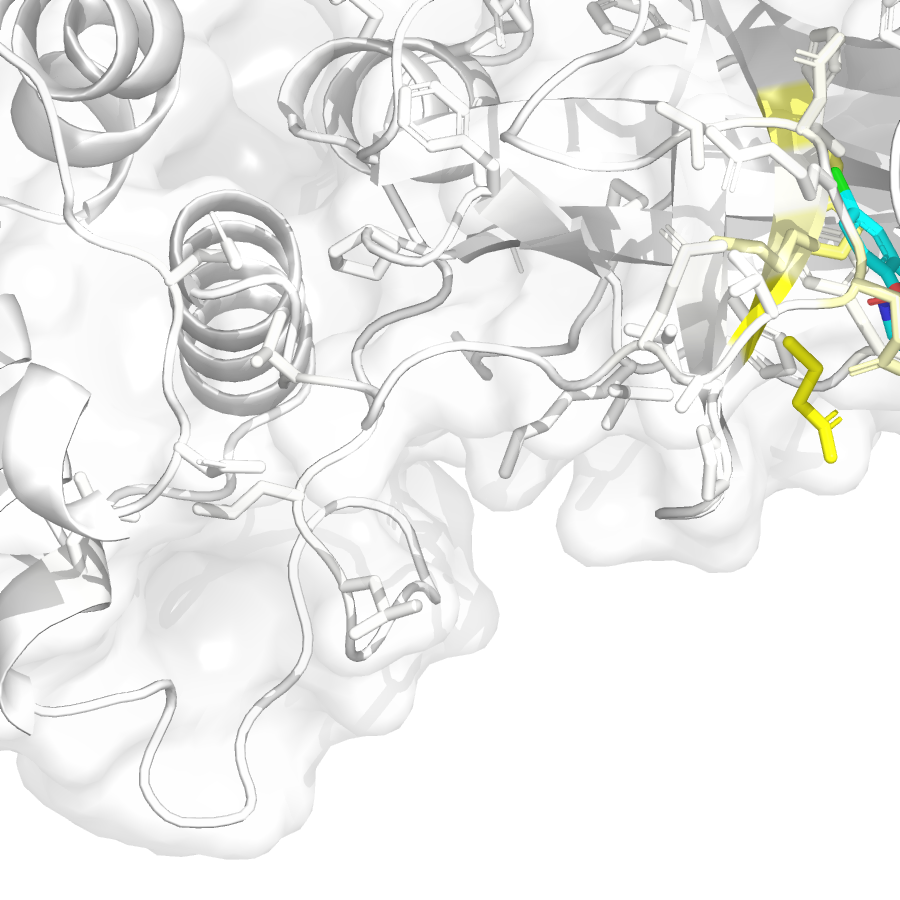

In [44]:
Image(filename=OUT / "summed_interactions_pymol_image.png", width=300, height=300)

We also may want to remove the ligand from the image, this can be done with the `show_ligand` flag: 

In [45]:
for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style()
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name],
        show_ligand=False, view=mpro_view, viewport_x=900, viewport_y=900)
    v.render(name=f"{interaction_name}_pymol_image_no_ligand", save_path=OUT)

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


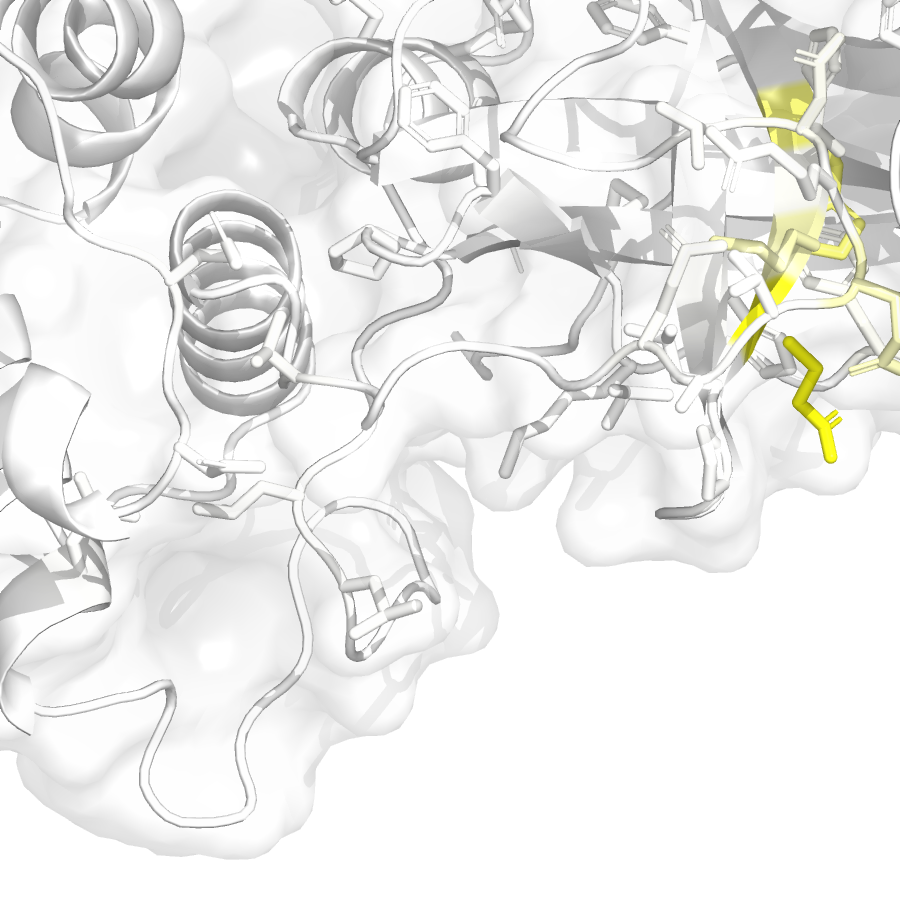

In [46]:
Image(filename=OUT / "summed_interactions_pymol_image_no_ligand.png", width=300, height=300) 

Sometimes when rendering residues as "sticks" they can appear to float above beta sheets. One way to get around this is to ensure beta sheets follow the backbone residues (at a cost of visual aesthetics) e.g.

In [47]:
for interaction_name, interaction_structure in pdb_interactions.items():
    v = PymolVisualizer(pdb=interaction_structure._path, verbose=False)
    v.set_style(flat_sheets=0)
    v.create_image(
        surface=True, ligand_col="cyan", spectrum_col=spectrum_colors[interaction_name],
        show_ligand=False, view=mpro_view, viewport_x=900, viewport_y=900)
    v.render(name=f"{interaction_name}_pymol_image_no_ligand_undulating_sheets", save_path=OUT)

PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900
PyMOL>viewport 900,900


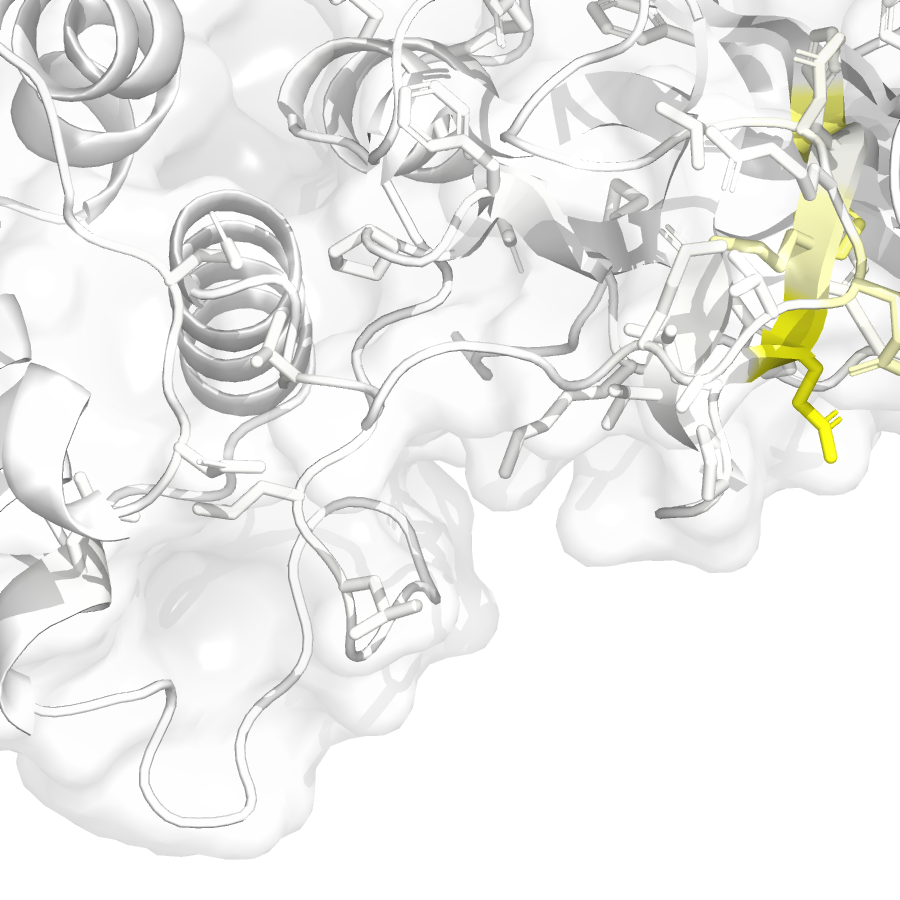

In [48]:
Image(filename=OUT / "summed_interactions_pymol_image_no_ligand_undulating_sheets.png", width=300, height=300)